In [1]:
import requests
from shapely.geometry import Polygon, LineString, Point, MultiPolygon, MultiLineString, MultiPoint
import shapely
import pandas as pd

In [ ]:
# TODO's:
#  - first
# in the discet osm class every geometrie is build from the nodes up when querried
# this is resource intensive espacily because geometries in osm tend to be reused
# so in future when a geometrie was build it will be saved back in build form
# to the dataframe this will be more memory intensive but i think it is worth the trade of
# - second
# I want to make the disection multithread able espacialy in context of the first
# todo this would I think immensily speed up the proccesing of the osm data
# the dataframe could be the common data storage for all threads
# and if one of the threads has solved a geomtry and stored it back in the dataframe
# the other threads can retrieve it and don't even need to solve it themselfs

In [2]:
overpass_url = "http://overpass-api.de/api/interpreter"

In [3]:
def generate_querry_poly(poly):
    # this function takes a shapely polygon and makes
    # an overpass filter polygon out of it
    # for the querry we will only support simple polygon
    # - no multipolygons and 
    # - no inner rings
    # because overpass does not support it
    # https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL#By_polygon_.28poly.29
    
    #test if polygon conforms
    assert isinstance(poly, shapely.geometry.polygon.Polygon), f'polygon is of {type(poly)} only shapely.geometry.polygon.Polygon is supported'
    assert not list(poly.interiors), 'polygon has inner rings this is not supported by overpass filters' 
    
    #simplyfy polygon if down to 101 cordinate pairs complex
    while len(list(poly.exterior.coords)) >= 101:
        # 0.1 is quite aggressive maybe 0.01 also works
        poly = poly.simplify(0.1, preserve_topology=True)
    
    # extracts the exterior coords and puts them into a string
    poly_string = ' '.join([f'{lat:.6f} {lon:.6f}' for lat,lon in list(poly.exterior.coords)])
    
    return poly_string


def json_from_osm(poly, mode='nwr', key=None, value=None, operand='='):
    
    kv_filter = ''
    if key:
        kv_filter = f'["{key}"]'
    if value:
        assert key, "you can't pass a value without a key"
        kv_filter = f'{kv_filter[:-1]}{operand}"{value}"]'

    query = f'''
            [out:json][timeout:25];
            (
              {mode}{kv_filter}(poly:"{generate_querry_poly(poly)}");
            );
            out body;
            >;
            out skel qt;
            '''
    
    respones = requests.get(overpass_url, params={'data': query})
    
    assert respones.ok, respones.text

    return respones.json()


class disect_osm:
    # when parsing osm data there exists a hugh issue with relations 
    # because they can contain multiple differnt kinds of geometries 
    # like polygons, lines, and points in the same thing they can even contain other
    # relations that then again contain different types of geometries
    # most osm parsers fail here
    # so my idea is to split every relation into its most basic components
    # so we get all features of relation a grouped by geometries type togehter 
    # with all the tags of realtion the relation
    # for this i need to drill done every relation until I hit the the basic geometries
    # points lines polygons and special case multiploygon
    
    def __init__(self, osm_json):
        self.osm_json = osm_json
        self._parse_osm_json()
    
    def generate_geometry(self, f_type, osmid):
        # osmid within a feautre type are unique
        # but its possible that there is a node relation and way with id 467

        # select the feature in question from the df
        try:
            # recusion does some times fail when the feature refference wasn't retrieved
            feature = self.feature_df[(self.feature_df['type']==f_type) & (self.feature_df['id']==osmid)].iloc[0]
        except:
            f_type = None
            geometry = None
            
        if f_type == 'node':
            geometry = {'point':feature['geometry']}
        
        if f_type == 'way':
            geometry = self._solve_ways(feature['geometry'])
        
        if f_type == 'relation':
            if feature['tags']['type'] == 'multipolygon':
                geometry = self._solve_relations_multipolygon(feature['geometry'])
            else:
                geometry = self._solve_relations(feature['geometry']) 
        
        return geometry
    
    def _parse_osm_json(self,):
        self.feature_list = []
    
        for element in self.osm_json['elements']:

            if element['type'] == 'node':
                self.feature = [element['type'],element['id'],Point(element['lon'],element['lat']),]

            elif element['type'] == 'way':
                self.feature = [element['type'],element['id'],element['nodes'],]

            elif element['type'] == 'relation':
                self.feature = [element['type'],element['id'],element['members'],]

            #not all elements have tags
            try:
                self.feature.append(element['tags'])                        
            except:
                self.feature.append(None) 

            self.feature_list.append(self.feature)

        self.feature_df = pd.DataFrame(self.feature_list,columns=['type','id','geometry','tags'])
    
    def _solve_ways(self, node_list):
        
        point_geometries = [self.generate_geometry('node',node_id)['point'] for node_id in node_list]
        
        # its faster to filter None later rather than in the comprehension above
        # otherwise I would querry the dataframe twice for one node    
        point_geometries = [geom for geom in point_geometries if geom]
        
        # its a polygon if first and last element are the same
        if node_list[0] == node_list[-1]:
            temp_poly = Polygon(point_geometries)

            # simple fix for invalid polygons
            if not temp_poly.is_valid:
                temp_poly = temp_poly.buffer(0)
            
            geom = {'polygon':temp_poly} 
        
        else:
            geom = {'line':LineString(point_geometries)}
            
        return geom
    
    def _solve_relations(self, member_list):
        geom = {'multipoint':[],
                'mulitline':[],
                'mulitpolygon':[]}
        
        for member in member_list:
            member_geom = self.generate_geometry(member['type'],member['ref'])
            
            if member_geom == None:
                # if no geometrie for this member can be found we skip it
                continue
            
            # since a member can also be a relation it can have multiple 
            # geometry types
            for geom_type in member_geom:
                if geom_type == 'point':
                    geom['multipoint'].append(member_geom[geom_type])
                if geom_type == 'multipoint':
                    # multi features need to split to be later be put togehter again
                    [geom['multipoint'].append(point) for point in list(member_geom[geom_type])]      
                
                if geom_type == 'line':
                    geom['mulitline'].append(member_geom[geom_type])
                if geom_type == 'mulitline':
                    # multi features need to split to be later be put togehter again
                    [geom['mulitline'].append(point) for point in list(member_geom[geom_type])]    
                
                if geom_type == 'polygon':
                    geom['mulitpolygon'].append(member_geom[geom_type])
                if geom_type == 'mulitpolygon':
                    # multi features need to split to be later be put togehter again
                    [geom['mulitpolygon'].append(point) for point in list(member_geom[geom_type])] 
                    
        geom_transform_func = {'multipoint':MultiPoint,
                               'mulitline':MultiLineString,
                               'mulitpolygon':MultiPolygon,}
        keys_to_delete = []
        for geom_type in geom:
            if geom[geom_type]:
                geom[geom_type] = geom_transform_func[geom_type](geom[geom_type])
            else:
                keys_to_delete.append(geom_type)
        
        for key in keys_to_delete:
            del geom[key]
        
        return geom
   
    def _solve_relations_multipolygon(self, member_list):
        # osm has special mulitpolygon rules
        # all the things that have an inner and an outer border are
        # multipolygons represented as relations
        # https://wiki.openstreetmap.org/wiki/Relation:multipolygon
        # this function strictly folows the documentation
        # i.e. it ignores points, other relations and incorrectly tagged ways
        
        # since not self-closed ways can be part of an multipolygon in osm
        # but shapely does not like that we are also closing all polygons
        member_dict = {'inner':[],'outer':[]}
        
        for member in member_list:
            member_dict[member['role']].append(member['ref'])
            
        unclosed_ways = []
        member_node_dict = {'inner':[],'outer':[]}
        member_geom_dict = {'inner':[],'outer':[]}
        # find and merge inner and outer unclosed ways
        
        for key in member_node_dict:
            for way_id in member_dict[key]:
                # this gets us the list of node ids a way consinsts of 
                way_nodes = self.feature_df[(self.feature_df['type']=='way') & (self.feature_df['id']==way_id)].iloc[0]['geometry']
                
                if not way_nodes[0] == way_nodes[-1]:
                    unclosed_ways.append(way_nodes)
                else:
                    member_node_dict[key].append(way_nodes)

                if unclosed_ways:
                    # if unclosed ways exist try to merge them
                    member_node_dict[key] += self._close_ways(unclosed_ways)

            # now we make polygons out of all the ways
            # complex list comprehesion ahead!
            # we itterate once over all node list and the indivdualy over all 
            # node_ids to get the geometry for each
            
            
            for node_list in member_node_dict[key]:
                _tmp_list = [self.generate_geometry('node',node_id)['point'] for node_id in node_list]
                # its faster to filter None later rather than in the comprehension above
                # otherwise I would querry the dataframe twice for one node    
                _tmp_list = [geom for geom in _tmp_list if geom]

                member_geom_dict[key].append(Polygon(_tmp_list))
            
        # now lastly we have to solve which polygon is the inner to which outer polygon
        multi_poly = self._solve_inner_outer(member_geom_dict)
        
        return {'mulitpolygon':multi_poly}
    
    def _close_ways(self,unclosed_ways):
        closed_ways = []

        while unclosed_ways:
            way = unclosed_ways.pop()

            # we pop up a way an try to merge it with any other of the ways
            for match_way in unclosed_ways:
                if way[-1] == match_way[0]:
                    # if they are a match we merge them and 
                    # remove the copy of the matched way
                    way = way[:-1] + match_way
                    unclosed_ways.remove(match_way)
                    break
            # if the way now is closed it goes into the closed way list
            if way[0] == way[-1]:
                closed_ways.append(way)

            # if not back into the pool of unclosed ways
            else:
                unclosed_ways.insert(0,way)

            # if something goes wrong and only one way is left in here
            # we break the loop 
            # this should not happen but osm data is wobbly
            if len(unclosed_ways) == 1:
                break

        return closed_ways
    
    def _solve_inner_outer(self,geom_dict):
        
        solved_polys = {}
        multi_list = []
        # first we calculate the are for each of the outer polygons
        # then sort them by size smalles first
        # the idea is that an inner ring the innering to 
        # the smallest possible outer polygon is that it is containt within
        outer_list = [(i,feature,feature.area) for i, feature in enumerate(geom_dict['outer'])]
        outer_list.sort(key=lambda tup: tup[2])
        
        for i,feature,area in outer_list:
            solved_polys[i] = {}
            solved_polys[i]['outer'] = feature
            solved_polys[i]['inner'] = []
        
        # here we itterate over all inner features and match them with an outer feature
        for inner_feature in geom_dict['inner']:
            for i,outer_feature,area in outer_list:
                if outer_feature.contains(inner_feature):
                    solved_polys[i]['inner'].append(inner_feature)

                    
        # lastly we make shapely single polygons out of all of them 
        for i in solved_polys:
            multi_list.append(Polygon(solved_polys[i]['outer'].exterior.coords,
                                      [inner_feature.exterior.coords for inner_feature in solved_polys[i]['inner']]))

        return MultiPolygon(multi_list)

In [4]:
q_poly = Polygon([(52.450425727741,13.286182880402),(52.458323725344,13.286182880402),(52.458323725344,13.299744129181),(52.450425727741,13.299744129181)])
osm_json = json_from_osm(q_poly)

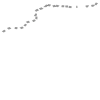

In [5]:
test =  disect_osm(osm_json)
test_multi = test.generate_geometry('relation',2669207)
test_multi['mulitpolygon']
#df[(df['type']=='way') & (df['id']==23045210)].iloc[0]['geometry']

In [6]:
import ipyleaflet
from ipyleaflet import Map, basemaps, basemap_to_tiles,GeoJSON, WKTLayer

geom_in_question = test.generate_geometry('relation',2669207)['mulitpolygon']

m = Map(
    basemap=basemaps.CartoDB.Positron,
    # for some reason lat lon are switch for centering the map
    center=(geom_in_question.centroid.coords[0][1],geom_in_question.centroid.coords[0][0]),
    zoom=14
)

# polygon = ipyleaflet.Polygon(
#     locations= [
#         list(poly.exterior.coords)
#     ],
#     color="green",
#     fill_color="green"
# )
# m.add_layer(polygon)

wlayer = WKTLayer(
    wkt_string=geom_in_question.wkt,
    #hover_style={"fillColor": "red"},
    fill_color="red",
    color="red",
)
m.add_layer(wlayer)

# geo_json = GeoJSON(
#     data=geojson_from_osm(poly,key='amenity',value='university'),
#     color="red",
#     fill_color="red"
# )

# m.add_layer(geo_json)


m

Map(center=[52.480674244638806, 13.326871945318803], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [12]:
test.feature_df[test.feature_df['id'] == 2669207]['tags'].iloc[0]

{'colour': '#15AC99',
 'from': 'U Krumme Lanke',
 'interval': '5',
 'name': 'U3: U Krumme Lanke => S+U Warschauer Straße',
 'network': 'Verkehrsverbund Berlin-Brandenburg',
 'network:metro': 'u-bahn',
 'network:short': 'VBB',
 'operator': 'Berliner Verkehrsbetriebe',
 'operator:short': 'BVG',
 'public_transport:version': '2',
 'ref': 'U3',
 'route': 'subway',
 'to': 'S+U Warschauer Straße',
 'type': 'route'}

In [ ]:
for row in test.feature_df[test.feature_df['type'] == 'relation'].iterrows():
    print(row[1]['id'])
    print(test.generate_geometry('relation',row[1]['id']))